Автор: Баранов Д.А. ИВТ 2.1
**Лабораторная работа: Временные ряды. Модель AR.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf

Загрузка данных и визуализация

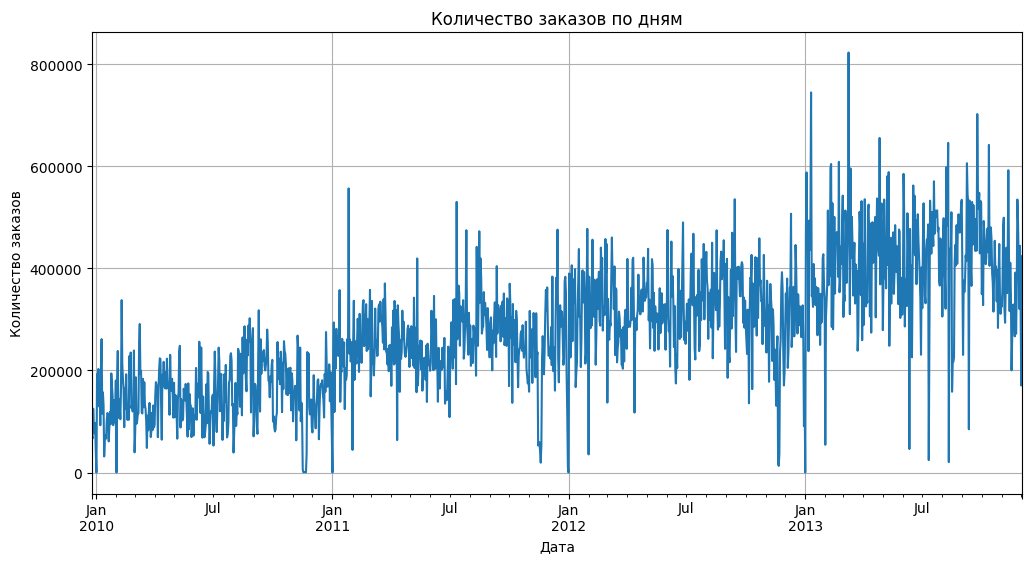

In [ ]:
data = pd.read_csv('tovar_moving.csv', parse_dates = ['date'], index_col = 'date')
data = data.sort_index()
ts = data['qty']

ts.plot(figsize = (12, 6), title = 'Количество заказов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Шаг 1: Отложить в **test** последнее значение временного ряда

In [ ]:
train = ts.iloc[:-1]
test = ts.iloc[-1]
print(f"Фактическое последнее значение (Test): {test}")

Фактическое последнее значение (Test): 423846.0


Шаг 2: Анализ временного ряда на наличие тренда и сезонности

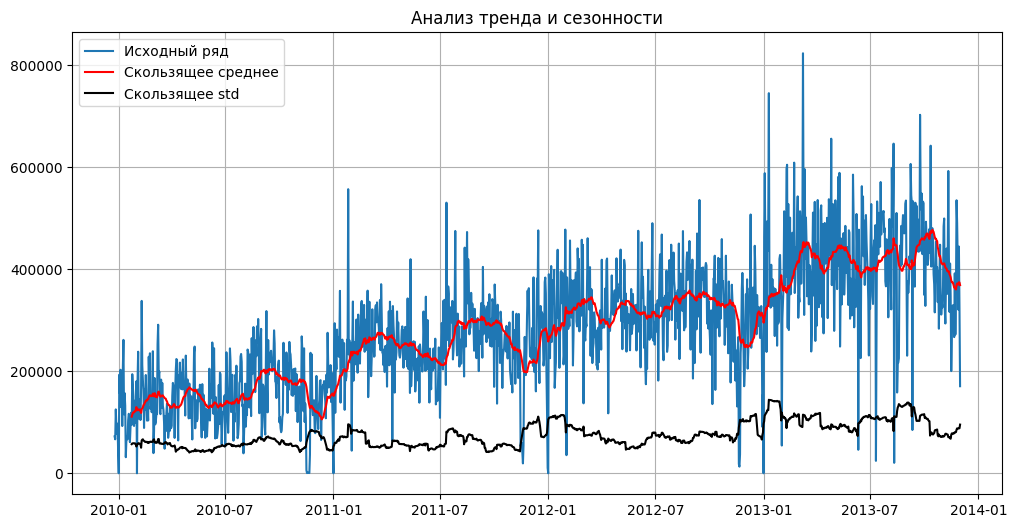

In [ ]:
# Скользящее среднее и стандартное отклонение
rolling_mean = train.rolling(window = 30).mean()
rolling_std = train.rolling(window = 30).std()

plt.figure(figsize = (12, 6))
plt.plot(train, label = 'Исходный ряд')
plt.plot(rolling_mean, color = 'red', label = 'Скользящее среднее')
plt.plot(rolling_std, color = 'black', label = 'Скользящее std')
plt.legend()
plt.title('Анализ тренда и сезонности')
plt.grid()
plt.show()

Вывод:
Скользящее среднее изменяется со временем, значит, есть тренд.

Присутствуют колебания со стабильной амплитудой через одинаковые промежутки времени, что указывает на наличие признаков сезонности.

Шаг 3: Экспоненциальное сглаживание (alpha = 0.7)


In [ ]:
alpha = 0.7
forecast_ses = train.ewm(alpha = alpha, adjust = False).mean().iloc[-1]
print(f"Прогноз с помощью экспоненциального сглаживания: {forecast_ses:.2f}")
print(f"Фактическое значение: {test:.2f}")

error_ses = abs(forecast_ses - test)
print(f"Ошибка прогноза экспоненциального сглаживания: {error_ses:.2f}")

Прогноз с помощью экспоненциального сглаживания: 225015.52
Фактическое значение: 423846.00
Ошибка прогноза экспоненциального сглаживания: 198830.48


Шаг 4: Проверка ряда на стационарность, определение порядка интегрирования

In [ ]:
adf_result = adfuller(train)
print('ADF Statisric (Исходный ряд):', adf_result[0])
print('p-value (Исходный ряд):', adf_result[1])

if adf_result[1] < 0.05:
  print("Ряд стационарный, интегрирование не требуется.")
  train_diff = train.copy()
  d = 0
else:
  print("Ряд нестационарный - требуется интегрирование (разность).\n")
  train_diff = train.diff().dropna()
  d = 1

  adf_result_diff = adfuller(train_diff)
  print('ADF Statistic (после первой разности):', adf_result_diff[0])
  print('p-value (после первой разности):', adf_result_diff[1])

  if adf_result_diff[1] < 0.05:
    print("Ряд после первой разности стал стационарным.")
  else:
    print("Ряд всё ещё не стационарный, возможно требуется ещё разность.")

ADF Statisric (Исходный ряд): -2.2553026410338006
p-value (Исходный ряд): 0.1867890312341643
Ряд нестационарный - требуется интегрирование (разность).

ADF Statistic (после первой разности): -13.780727380503698
p-value (после первой разности): 9.307227521343053e-26
Ряд после первой разности стал стационарным.


Шаг 5: Определение порядка модели AR по графику частичной автокорреляции (PACF)

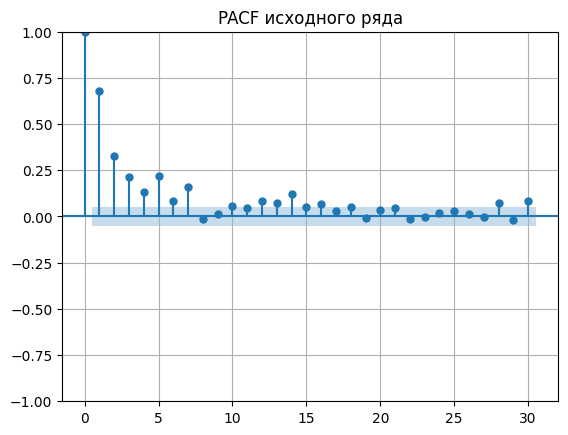

In [ ]:
plot_pacf(train.dropna(), lags = 30, method = 'ywm')
plt.title('PACF исходного ряда')
plt.grid()
plt.show()

Значения PACF значительно снижаются после первого лага и выходят за доверительный интервал. Это указывает на то, что порядок модели AR(p) равен 2.

Шаг 6: Построение модели AR и предсказание последнего значения ряда.

In [ ]:
model = AutoReg(train, lags = 2, old_names = False)
model_fit = model.fit()

forecast_ar = model_fit.predict(start = len(train), end = len(train))
print(f"Прогноз AR модели: {forecast_ar.iloc[0]:.2f}")

error_ar = abs(forecast_ar.iloc[0] - test)
print(f"Ошибка прогноза AR модели: {error_ar:.2f}\n")

Прогноз AR модели: 244842.05
Ошибка прогноза AR модели: 179003.95



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Шаг 7: Сравнение результатов

In [ ]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 200)

comparison = pd.DataFrame({
    'Метод': ['Экспоненциальное сглаживание (alpha = 0.7)', 'Авторегрессия (AR(2))'],
    'Прогноз': [round(forecast_ses, 2), round(forecast_ar.iloc[0], 2)],
    'Фактическое значение': [test, test],
    'Ошибка прогноза': [round(error_ses, 2), round(error_ar, 2)]
})

print(comparison.to_string(
    index = False,
    formatters = {
        'Метод': '{:^50}'.format,
        'Прогноз': '{:^15,.2f}'.format,
        'Фактическое значение': '{:^15,.2f}'.format,
        'Ошибка прогноза': '{:^15,.2f}'.format
    },
    justify = 'center')
)

if error_ses < error_ar:
  print("\nМетод экспоненциального сглаживания дал более точный прогноз.")
else:
  print("\nМодель авторегрессии дала более точный прогноз.")

                      Метод                            Прогноз     Фактическое значение Ошибка прогноза
    Экспоненциальное сглаживание (alpha = 0.7)       225,015.52        423,846.00         198,830.48   
              Авторегрессия (AR(2))                  244,842.05        423,846.00         179,003.95   

Модель авторегрессии дала более точный прогноз.
